# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Q3: Solving Four Rooms using semi-gradient SARSA with state aggregation


In [7]:
""" Four Rooms Environment Implementation
"""
class FourRooms(object):
    def __init__(self):
        # We define the grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # We define the observation space consisting of all empty cells
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # We define the action space
        self.action_space = {'up': np.array([0, 1]),
                             'down': np.array([0, -1]),
                             'left': np.array([-1, 0]),
                             'right': np.array([1, 0])}
        self.action_names = ['up', 'down', 'left', 'right']

        # We define the start location
        self.start_location = [0, 0]

        # We define the goal location
        self.goal_location = [10, 10]

        # We find all wall cells
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, we define a timeout: maximal time steps = 459
        self.max_time_steps = 459

        # We define other useful variables
        self.agent_location = None  # track the agent's location in one episode.
        self.action = None  # track the agent's action
        self.t = 0  # track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates to the Four Rooms coordinates (i.e, The origin locates at bottom left).
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): a list variable consists of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): a list variable consists of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # We reset the agent's location to the start location
        self.agent_location = self.start_location

        # We reset the timeout tracker to be 0
        self.t = 0

        # We set the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (string): a string variable (i.e., "UP"). All feasible values are ["up", "down", "left", "right"].
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == "left" or action == "right":
                action = np.random.choice(["up", "down"], 1)[0]
            else:
                action = np.random.choice(["right", "left"], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_space[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward
        reward = 1.0 if next_agent_location == self.goal_location else 0.0

        # Check the termination
        # If the agent reaches the goal, reward = 1, done = True
        # If the time steps reaches the maximal number, reward = 0, done = True.
        if reward == 1.0 or self.t == self.max_time_steps:
            terminated = True
        else:
            terminated = False

        # Update the agent's location, action and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, False, {}

    def render(self):
        # plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        my_env = FourRooms()
        state, _ = my_env.reset()

        for _ in range(100):
            action = np.random.choice(list(my_env.action_space.keys()), 1)[0]

            next_state, reward, done, _, _ = my_env.step(action)
            my_env.render()

            if done:
                state, _ = my_env.reset()
            else:
                state = next_state

In [32]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    # save the figure
    plt.savefig(f"{fig_title}.png", dpi=200)

    plt.show()

# Q3 - (a): Implement the semi-gradient SARSA

As described in the question, you are asked to implement the semi-gradient SARSA with a very simple state aggregation strategy. That is aggregating both states and actions to itself. Indeed, this will have similar results as applying *tabular* SARSA directly. 

**Please implement the following state aggregation strategy**

- For each state, its aggregated state is itself. E.g. [0, 0] is aggregated to [0, 0] only. 
- For each action, its aggregated action is also itself.

In [62]:
class SemiGradientSARSAAgent(object):
    def __init__(self, env, info):
        """
        Function to initialize the semi-gradient SARSA agent
        Args:
            env: the environment that the agent interacts with
            info (dict): a dictionary variable contains all necessary parameters.

        Note that: In this question, we will implement a simple state aggregation strategies.
                   Specifically, we design the following function approximation:
                   1. Feature: we use the one-hot encoding to compute the feature for each state-action pair.
                               E.g., state = [0, 0] and action = "Up" (state-action pair) will correspond to
                               a unique one-hot representation $f(s, a) = [0, 0, 0, 1, 0, ..., 0]$.
                   2. Weights: we define a weight vector $w$ having the sample shape as the feature vector.
                               Specifically, the Q(s, a) can be estimated by Q(s, a) = w^{T} * f(s, a)

        Importantly, as described in the question, we only aggregate the states.
        """
        # Store the environment
        self.env = env

        """ Learning parameters for semi-gradient SARSA """
        # Store the number of learning episodes
        self.episode_num = info['episode_num']

        # Store the update step size alpha
        self.alpha = info['alpha']

        # Store the discount factor
        self.gamma = info['gamma']

        # Initialize the epsilon
        self.epsilon = info['epsilon']

        # Store the other hyerparameters
        self.params = info

        """ State aggregation for semi-gradient SARSA """
        # Compute the total number of state after the aggregation
        self.state_space, self.state_num = self.create_state_aggregation()

        # Compute the total number of the actions
        self.action_num = len(self.env.action_names)

        """ Function approximation for semi-gradient SARSA"""
        # We create a weight with shape |S| * |A|
        self.weights_fn = np.zeros((self.state_num * self.action_num))

        # We construct a numpy array that contains the one-hot features for all state-action pairs.
        # The size is (|S| * |A|) x (|S| * |A|).
        # Each i-th row is the one-hot encoding for state-action pair with index i.
        self.feature_arr = np.eye(self.state_num * self.action_num)

    def create_state_aggregation(self):
        """
        Function that returns the aggregated state space and the number of the aggregated states.
        """
        
        """CODE HERE: your state aggregation strategy.
           
           You have to return:
            1. the aggregated state space (Any data structure that you find it easier to render the index of the 
               aggregated state.)
            2. the number of the aggregated states (int)
            
        """
        
        # compute the aggregated state space based on the state aggregation strategy
        aggregated_state_space = self.env.observation_space

        # compute the number of the state in the aggregated state space
        aggregate_state_num = len(aggregated_state_space)

        return aggregated_state_space, aggregate_state_num

    def _aggregate_state_idx(self, state):
        """
        Function returns the index of aggregated state given an original state

        Args:
            state (list): original state
        """
        
        """CODE HERE: based on your state aggregation, return the index of the aggregated state given an original
           state. 
           
           You have to return:
           1. index (int) of the aggregated state given the original state
        """
        state=tuple(state)
        state_idx = self.env.observation_space.index(state)
        return state_idx

    def _aggregate_action_idx(self, action):
        """
        Function returns the index of aggregated action.
        Args:
            action (string): name of the action

        To be simple, here, one action only aggregates to itself
        """
        return self.env.action_names.index(action)

    def _get_state_action_feature(self, state, action):
        """
        Function that returns the one-hot feature given a state-action pair.

        Args:
            state (list): original state
            action (string): name of the action
        """
        # Get the unique index of the aggregated state
        state_index = self._aggregate_state_idx(state)
        # Get the unique index of the aggregated action
        action_index = self._aggregate_action_idx(action)
        # Compute the state(aggregated)-action index
        state_action_index = self.state_num * action_index + state_index
        # Get the one-hot feature of the state
        return self.feature_arr[state_action_index]

    def function_approximation(self, state, action):
        """
        Function that computes the Q value given a state-action pair using linear function approximation.
        Args:
            state (list): original state
            action (string): name of the action
        """
        state_action_feature = self._get_state_action_feature(state, action)
        return np.matmul(state_action_feature.T, self.weights_fn)

    def render_q_value(self, state, action):
        """
        Function that returns the Q value given a state-action pair

        Args:
            state (list): original state
            action (string): name of the action
        """
        return self.function_approximation(state, action)



    def epsilon_greedy_policy(self, state):
        """
        Function implements the epsilon-greedy policy
        Args:
            state (list): original state
        """
        """CODE HERE:
           implement the epsilon-greedy policy using function approximation. Break ties if happens 
           
           You should return:
           1. name of the action (string)
        """
        # q_values=self.feature_arr.T * self.weights_fn
        if random.random() < self.epsilon:  # with p = epsilon, we randomly sample an action
            action= random.sample(self.env.action_names, 1)[0]
        else:  # With p = 1 - epsilon, derive a greedy policy from the Q table
            state_idx = self._aggregate_state_idx(state)
            q_values = self.q_table(state_idx)
            max_action_list = np.where(q_values == q_values.max())[0].tolist()
            max_action_idx = random.sample(max_action_list, 1)[0]
            action= self.env.action_names[max_action_idx]  # break ties

        return action


    def update_weights(self, s, a, r, s_prime, a_prime):
        """
        Function that updates the weights using semi-gradients

        Args:
            s (list): original state
            a (string): action name
            r (float): reward
            s_prime (list): original next state
            a_prime (string): next action name
        """
        """ CODE HERE:
            implement the update of the semi-gradient SARSA
            
            You should update "self.weights_fn"
        """
        # check if s_prime is the termination state

        # # q_values=self.feature_arr.T * self.weights_fn
        # s=tuple(s)
        # s_prime=tuple(s_prime)
        # s_id=self._aggregate_state_idx(s)
        # a_id=self._aggregate_action_idx(a)
        # ns_idx=self._aggregate_state_idx(s_prime)
        # na_id=self._aggregate_action_idx(a_prime)
        # gra=np.zeros((self.action_num,self.state_num*self.action_num))
        # gra[a_id,s_id+a_id]=1
        # if s_prime==self.env.goal_location:
        #     weights=self.weights_fn[a_id:ns_idx+na_id]
        #     weights += self.alpha*(r-self.q_table_w(s_id))*gra
        #     self.weights_fn[a_id:ns_idx+na_id]=weights
            

        # else:
        #     action=self.epsilon_greedy_policy(s_prime)
        #     action_id=self._aggregate_action_idx(action)
        #     weights=self.weights_fn[a_id:ns_idx+na_id]
        #     print(gra.shape)
        #     weights += self.alpha*(r+ self.gamma*self.q_table_w(ns_idx)-self.q_table_w(s_id))*gra
        #     self.weights_fn[a_id:ns_idx+na_id]=weights
        #     s=s_prime
        #     a=action


           

        
        
        # update the weights

    def run(self):
        # Save the discounted return for each episode
        discounted_returns = []

        # Semi-gradient SARSA starts
        for ep in tqdm.trange(self.episode_num):
            """CODE HERE:
               Implement the pseudocode of the Semi-gradient SARSA
            """
            # Reset the agent to initial STATE at the beginning of every episode
            initial_state,_=self.env.reset()
            initial_state=tuple(initial_state)

            # Render an ACTION based on the initial STATE
            action=self.epsilon_greedy_policy(initial_state)

            # Store rewards to compute return G for the current episode.
            reward_list = []
            
            # Loop the episode
            for t in range(self.env.max_time_steps):
                # Take the ACTION and observe REWARD and NEXT STATE
                next_s,reward,done,_,_=self.env.step(action)
                next_s=tuple(next_s)

                # Given the NEXT STATE, choose the NEXT ACTION
                new_action=self.epsilon_greedy_policy(next_s)

                # Update the weights of the function using semi-gradient SARSA
                weights=self.update_weights(initial_state,action,reward,next_s,new_action)
                # Using STATE, ACTION, REWARD, NEXT STATE, NEXT ACTION
                
                """DO NOT CHANGE BELOW"""
                # Save the reward for plotting
                reward_list.append(reward)

                # Reset the environment
                if done:
                    break
                else:
                    state = next_state
                    action = next_action

            # compute the discounted return for the current episode
            G = 0
            for reward in reversed(reward_list):
                G = reward + self.gamma * G
            discounted_returns.append(G)

        return discounted_returns

In [63]:
if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params = {
        "episode_num": 100,
        "alpha": 0.1,
        "gamma": 0.99,
        "epsilon": 0.1
    }

    # set running trials. You can try run_trial = 5 for debugging
    run_trial = 10

    # run multiple trials
    results = []
    for _ in range(run_trial):
        # create the environment
        my_env = FourRooms()

        # run semi-gradient SARSA
        my_agent = SemiGradientSARSAAgent(my_env, params)
        res = my_agent.run()

        # save result for each running trial
        results.append(np.array(res))

  0%|          | 0/100 [00:00<?, ?it/s]

(4, 416)


ValueError: operands could not be broadcast together with shapes (80,) (4,416) (80,) 

/home/amina/.local/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/amina/.local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/amina/.local/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: tuple index out of range

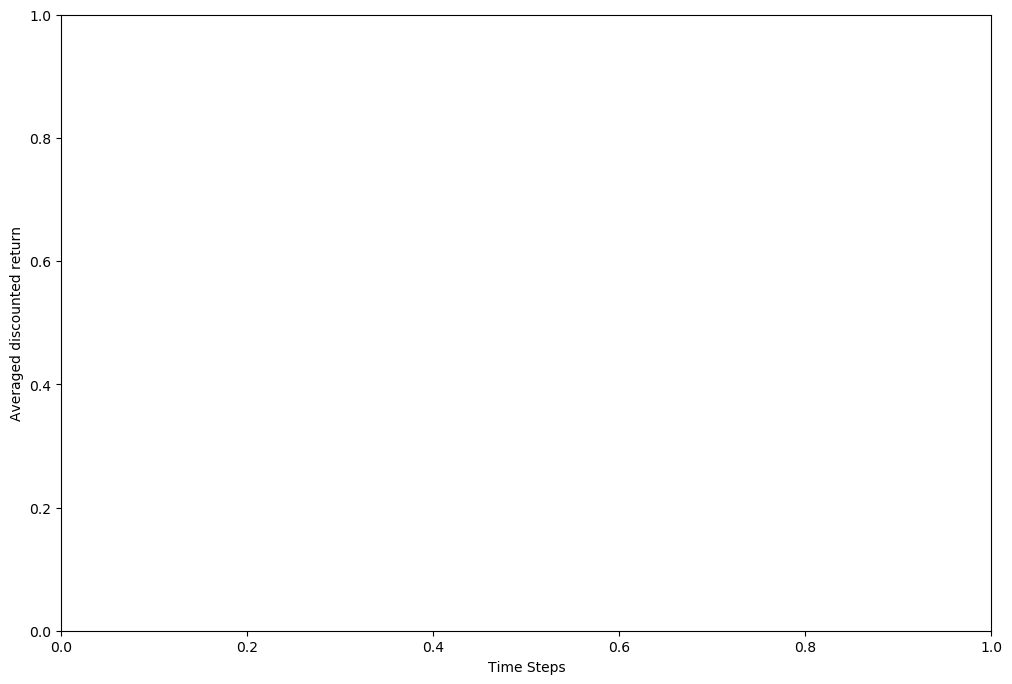

In [47]:
plot_curves([np.array(results)], ["semi-gradient SARSA"], ["b"],
            "Averaged discounted return", "Q3 - (a): semi-gradient SARSA")

# Q3 - (b) [5180]: Implement the semi-gradient SARSA with Tile-based/Room-based aggregation.

As described in the question, you are asked to implement the semi-gradient SARSA with **Tile-based/Room-based** state aggregation strategy. That is grouping the nearby states in a n x n (i.e., n = 2) tile as one aggregated state and grouping states in one room as one aggregated state. 

**Plot**: Plot the learning curves of tile size n = 2 and Room-based aggregation in the same plot. You can use the plot function above to generate the plot. 

In [ ]:
""" Implement the Tile-based Agent here. We inherit it from the "SemiGradientSARSAAgent" above
"""
class TileAgent(SemiGradientSARSAAgent):
    def __init__(self, env, info):
        """
        Function to initialize the semi-gradient SARSA agent
        Args:
            env: the environment that the agent interacts with
            info (dict): a dictionary variable contains all necessary parameters.

        Note that: In this question, we will implement a simple state aggregation strategies.
                   Specifically, we design the following function approximation:
                   1. Feature: we use the one-hot encoding to compute the feature for each state-action pair.
                               E.g., state = [0, 0] and action = "Up" (state-action pair) will correspond to
                               a unique one-hot representation $f(s, a) = [0, 0, 0, 1, 0, ..., 0]$.
                   2. Weights: we define a weight vector $w$ having the sample shape as the feature vector.
                               Specifically, the Q(s, a) can be estimated by Q(s, a) = w^{T} * f(s, a)

        Importantly, as described in the question, we only aggregate the states.
        """
        super().__init__(env, info)
        
        """ State aggregation for semi-gradient SARSA """
        # Compute the total number of state after the aggregation
        self.state_space, self.state_num = self.create_state_aggregation()

        # Compute the total number of the actions
        self.action_num = len(self.env.action_names)

        """ Function approximation for semi-gradient SARSA"""
        # We create a weight with shape |S| * |A|
        self.weights_fn = np.zeros((self.state_num * self.action_num))

        # We construct a numpy array that contains the one-hot features for all state-action pairs.
        # The size is (|S| * |A|) x (|S| * |A|).
        # Each i-th row is the one-hot encoding for state-action pair with index i.
        self.feature_arr = np.eye(self.state_num * self.action_num)

    def create_state_aggregation(self):
        """
        Function that returns the aggregated state space and the number of the aggregated states.
        """
        
        """CODE HERE: Implement the Tile-based state aggregation here.
           Hint: you can manually discretize the original states using the Tile-based method.
           For example, you can copy the grid from the Four Rooms environment
           and manually aggregate the states (value = 0) in the grid. 
           
           You have to return:
            1. the aggregated state space (Any data structure that you find it easier to render the index of the 
               aggregated state.)
            2. the number of the aggregated states (int)
        """
        
        # define the aggregated state space using Tile-based method (2x2)
        aggregated_state_space = None

        # aggregate the state space
        aggregate_state_num = None

        return aggregated_state_space, aggregate_state_num

    def _aggregate_state_idx(self, state):
        """
        Function returns the index of aggregated state given an original state

        Args:
            state (list): original state
        """
        """CODE HERE: based on your state aggregation, return the index of the aggregated state given an original
           state. 
           
           You have to return:
           1. index (int) of the aggregated state given the original state
        """
        
        # render the index of the aggregated state
        state_idx = None
        return state_idx

In [ ]:
""" Implement the Room-based Agent here. We inherit it from the "SemiGradientSARSAAgent" above
"""
class RoomAgent(SemiGradientSARSAAgent):
    def __init__(self, env, info):
        """
        Function to initialize the semi-gradient SARSA agent
        Args:
            env: the environment that the agent interacts with
            info (dict): a dictionary variable contains all necessary parameters.

        Note that: In this question, we will implement a simple state aggregation strategies.
                   Specifically, we design the following function approximation:
                   1. Feature: we use the one-hot encoding to compute the feature for each state-action pair.
                               E.g., state = [0, 0] and action = "Up" (state-action pair) will correspond to
                               a unique one-hot representation $f(s, a) = [0, 0, 0, 1, 0, ..., 0]$.
                   2. Weights: we define a weight vector $w$ having the sample shape as the feature vector.
                               Specifically, the Q(s, a) can be estimated by Q(s, a) = w^{T} * f(s, a)

        Importantly, as described in the question, we only aggregate the states.
        """
        super().__init__(env, info)
        
        """ State aggregation for semi-gradient SARSA """
        # Compute the total number of state after the aggregation
        self.state_space, self.state_num = self.create_state_aggregation()

        # Compute the total number of the actions
        self.action_num = len(self.env.action_names)

        """ Function approximation for semi-gradient SARSA"""
        # We create a weight with shape |S| * |A|
        self.weights_fn = np.zeros((self.state_num * self.action_num))

        # We construct a numpy array that contains the one-hot features for all state-action pairs.
        # The size is (|S| * |A|) x (|S| * |A|).
        # Each i-th row is the one-hot encoding for state-action pair with index i.
        self.feature_arr = np.eye(self.state_num * self.action_num)

    def create_state_aggregation(self):
        """
        Function that returns the aggregated state space and the number of the aggregated states.
        """
        """CODE HERE: your state aggregation strategy. Hint: you can start with a simple state aggregation
           that just aggregate each state to itself. In other words, the aggregated state space is just
           the original state space.
           
           You have to return:
            1. the aggregated state space (Any data structure that you find it easier to render the index of the 
               aggregated state.)
            2. the number of the aggregated states (int)
        """

        aggregated_state_space = None

        # aggregate the state space
        aggregate_state_num = None

        return aggregated_state_space, aggregate_state_num

    def _aggregate_state_idx(self, state):
        """
        Function returns the index of aggregated state given an original state

        Args:
            state (list): original state
        """
        """CODE HERE: based on your state aggregation, return the index of the aggregated state given an original
           state. 
           
           You have to return:
           1. index (int) of the aggregated state given the original state
        """
        state_idx = None
        return state_idx

In [ ]:
if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params = {
        "episode_num": 100,
        "alpha": 0.1,
        "gamma": 0.99,
        "epsilon": 0.1
    }

    # set running trials; You can trial run_trial = 5 to debug
    run_trial = 10

    # run experiment for the Tile-based method
    results_tile = []
    for _ in range(run_trial):        
        # create the environment
        my_env = FourRooms()

        # run semi-gradient SARSA with Tile-based method with tile size n = 2
        my_agent = TileAgent(my_env, params)
        res = my_agent.run()

        # save result for each running trial
        results_tile.append(np.array(res))
        
    # run experiment for the Room-based method
    results_room = []
    for _ in range(run_trial):        
        # create the environment
        my_env = FourRooms()

        # run semi-gradient SARSA with Room-based method
        my_agent = RoomAgent(my_env, params)
        res = my_agent.run()

        # save result for each running trial
        results_room.append(np.array(res))

In [ ]:
# plot the results
plot_curves([np.array(results), np.array(results_tile), np.array(results_room)],
            ["State-aggregation: identical", "State-aggregation: Tile = 2x2", "State aggregation: Room-based"],
            ["b", "r", "g"],
            "Averaged discounted return", "Q3 - (b): Comparison between three state aggregation strategies")

# Q3 - (d):  Adapt your implementation of semi-gradient one-step SARSA for linear function approximation

In [ ]:
"""Implement your code here."""

# Q3 - (e) [5180]: Implement the following two features, and plot the learning curves.

In [ ]:
"""Implement your code here."""

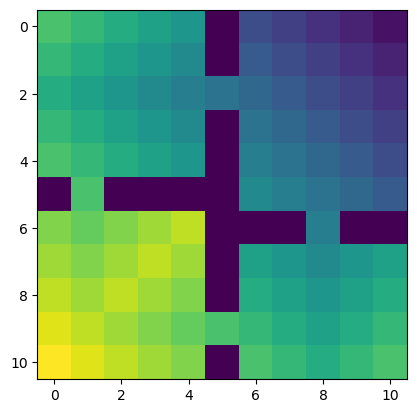

In [60]:
"""The distance matrix is here"""

distance_matrix = np.array([[14, 13, 12, 11, 10, -1,  4,  3,  2,  1,  0],
                            [13, 12, 11, 10,  9, -1,  5,  4,  3,  2,  1],
                            [12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2],
                            [13, 12, 11, 10,  9, -1,  7,  6,  5,  4,  3],
                            [14, 13, 12, 11, 10, -1,  8,  7,  6,  5,  4],
                            [-1, 14, -1, -1, -1, -1,  9,  8,  7,  6,  5],
                            [16, 15, 16, 17, 18, -1, -1, -1,  8, -1, -1],
                            [17, 16, 17, 18, 17, -1, 11, 10,  9, 10, 11],
                            [18, 17, 18, 17, 16, -1, 12, 11, 10, 11, 12],
                            [19, 18, 17, 16, 15, 14, 13, 12, 11, 12, 13],
                            [20, 19, 18, 17, 16, -1, 14, 13, 12, 13, 14]])
plt.imshow(distance_matrix)
plt.show()